1. Install Dependencies and Setup

In [66]:
!pip install tensorflow opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import tensorflow as tf
import os

In [95]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2. Remove Dodgy Images

In [96]:
import cv2
import imghdr

In [114]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [115]:
#data_dir = 'data' 
data_dir = '/content/drive/MyDrive/data_diseases'
os.listdir(data_dir)

['anaplasmosis', 'theileriosis', 'babesiosis']

In [116]:
image_exts = ['jpeg','jpg', 'bmp', 'png', 'webp']

In [117]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list /content/drive/MyDrive/data_diseases/theileriosis/.DS_Store
Image not in ext list /content/drive/MyDrive/data_diseases/babesiosis/.DS_Store


3. Load Data

In [118]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [119]:
#data = tf.keras.utils.image_dataset_from_directory('data')
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data_diseases', batch_size=12)

Found 292 files belonging to 3 classes.


In [120]:
data_iterator = data.as_numpy_iterator()

In [121]:
batch = data_iterator.next()
class_dict = {}
for i, class_label in enumerate(sorted(os.listdir('/content/drive/MyDrive/data_diseases'))):
    class_dict[class_label] = i

print("Class numbers:")
for class_label, class_num in class_dict.items():
    print(f"{class_label}: {class_num}")


Class numbers:
anaplasmosis: 0
babesiosis: 1
theileriosis: 2


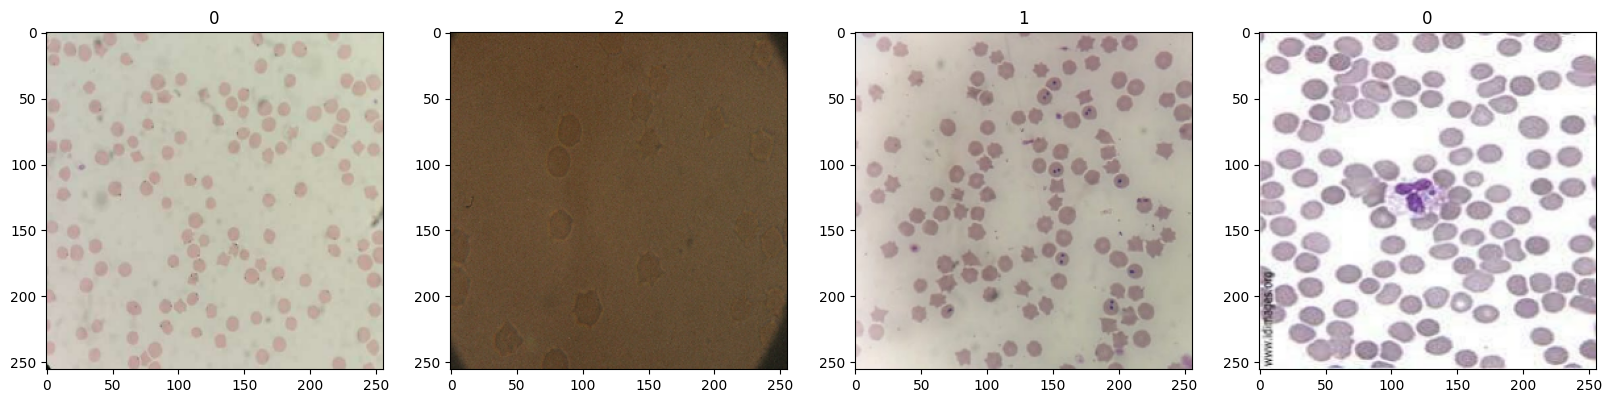

In [122]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [123]:
data = data.map(lambda x,y: (x/255, y))


In [124]:
len(data)

25

In [ ]:
data.as_numpy_iterator().next()

5. Split data

In [126]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [127]:
test_size

2

In [128]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

6. Build Deep Learning Model

In [129]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [131]:
model = Sequential()

In [132]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [133]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

7. Train

In [135]:
logdir='logs'

In [136]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#running more + complex layers in between iterations


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

KeyboardInterrupt: ignored

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#This is for batch size = 4

Epoch 1/40
101/101 [==============================] - 51s 493ms/step - loss: 1.3992 - accuracy: 0.4257 - val_loss: 1.1944 - val_accuracy: 0.4741
Epoch 2/40
101/101 [==============================] - 55s 541ms/step - loss: 1.1847 - accuracy: 0.4901 - val_loss: 1.1588 - val_accuracy: 0.5000
Epoch 3/40
101/101 [==============================] - 44s 436ms/step - loss: 1.0630 - accuracy: 0.5718 - val_loss: 1.0539 - val_accuracy: 0.5431
Epoch 4/40
101/101 [==============================] - 47s 459ms/step - loss: 1.0809 - accuracy: 0.5916 - val_loss: 1.3104 - val_accuracy: 0.4741
Epoch 5/40
101/101 [==============================] - 54s 529ms/step - loss: 1.1839 - accuracy: 0.5792 - val_loss: 1.1514 - val_accuracy: 0.5603
Epoch 6/40
101/101 [==============================] - 44s 437ms/step - loss: 1.0350 - accuracy: 0.5817 - val_loss: 1.2827 - val_accuracy: 0.5000
Epoch 7/40
101/101 [==============================] - 57s 562ms/step - loss: 1.0208 - accuracy: 0.5916 - val_loss: 1.8048 - val_ac

In [58]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#This is for batch size = 12

Epoch 1/40
34/34 [==============================] - 59s 2s/step - loss: 1.3229 - accuracy: 0.4020 - val_loss: 1.2146 - val_accuracy: 0.5093
Epoch 2/40
34/34 [==============================] - 55s 2s/step - loss: 1.2516 - accuracy: 0.4853 - val_loss: 1.1799 - val_accuracy: 0.5093
Epoch 3/40
34/34 [==============================] - 43s 1s/step - loss: 1.1801 - accuracy: 0.4902 - val_loss: 1.2365 - val_accuracy: 0.4630
Epoch 4/40
34/34 [==============================] - 52s 2s/step - loss: 1.1791 - accuracy: 0.5025 - val_loss: 1.1537 - val_accuracy: 0.4722
Epoch 5/40
34/34 [==============================] - 55s 2s/step - loss: 1.2771 - accuracy: 0.5343 - val_loss: 1.1447 - val_accuracy: 0.5648
Epoch 6/40
34/34 [==============================] - 55s 2s/step - loss: 1.1005 - accuracy: 0.5858 - val_loss: 1.0994 - val_accuracy: 0.5741
Epoch 7/40
34/34 [==============================] - 47s 1s/step - loss: 1.0142 - accuracy: 0.5980 - val_loss: 1.3517 - val_accuracy: 0.5000
Epoch 8/40
34/34 [==

8. Plot performance

In [93]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#removed uninfected samples due to less data, batch size = 12

Epoch 1/40
30/30 [==============================] - 41s 1s/step - loss: 1.2799 - accuracy: 0.4361 - val_loss: 1.1105 - val_accuracy: 0.4271
Epoch 2/40
30/30 [==============================] - 40s 1s/step - loss: 1.0389 - accuracy: 0.4806 - val_loss: 0.9745 - val_accuracy: 0.5521
Epoch 3/40
30/30 [==============================] - 51s 2s/step - loss: 0.9865 - accuracy: 0.5278 - val_loss: 1.0239 - val_accuracy: 0.5208
Epoch 4/40
30/30 [==============================] - 49s 2s/step - loss: 0.9897 - accuracy: 0.5083 - val_loss: 0.8736 - val_accuracy: 0.6146
Epoch 5/40
30/30 [==============================] - 50s 2s/step - loss: 0.9234 - accuracy: 0.6000 - val_loss: 0.9133 - val_accuracy: 0.5417
Epoch 6/40
30/30 [==============================] - 51s 2s/step - loss: 0.8536 - accuracy: 0.5972 - val_loss: 1.0203 - val_accuracy: 0.6458
Epoch 7/40
30/30 [==============================] - 50s 2s/step - loss: 0.8469 - accuracy: 0.6000 - val_loss: 0.9905 - val_accuracy: 0.6354
Epoch 8/40
30/30 [==

NotFoundError: ignored

In [137]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#ran through test data and simplified it further, hugely reduced class imbalance

Epoch 1/40
17/17 [==============================] - 33s 2s/step - loss: 1.4128 - accuracy: 0.3578 - val_loss: 1.0924 - val_accuracy: 0.3667
Epoch 2/40
17/17 [==============================] - 28s 2s/step - loss: 1.0396 - accuracy: 0.5098 - val_loss: 0.9698 - val_accuracy: 0.5500
Epoch 3/40
17/17 [==============================] - 27s 2s/step - loss: 1.0295 - accuracy: 0.4559 - val_loss: 0.9820 - val_accuracy: 0.5167
Epoch 4/40
17/17 [==============================] - 24s 1s/step - loss: 0.9617 - accuracy: 0.5000 - val_loss: 1.0618 - val_accuracy: 0.4000
Epoch 5/40
17/17 [==============================] - 25s 1s/step - loss: 1.0197 - accuracy: 0.5049 - val_loss: 1.0136 - val_accuracy: 0.5167
Epoch 6/40
17/17 [==============================] - 23s 1s/step - loss: 0.9476 - accuracy: 0.5637 - val_loss: 0.9962 - val_accuracy: 0.5333
Epoch 7/40
17/17 [==============================] - 29s 2s/step - loss: 0.8029 - accuracy: 0.6225 - val_loss: 0.9680 - val_accuracy: 0.5000
Epoch 8/40
17/17 [==

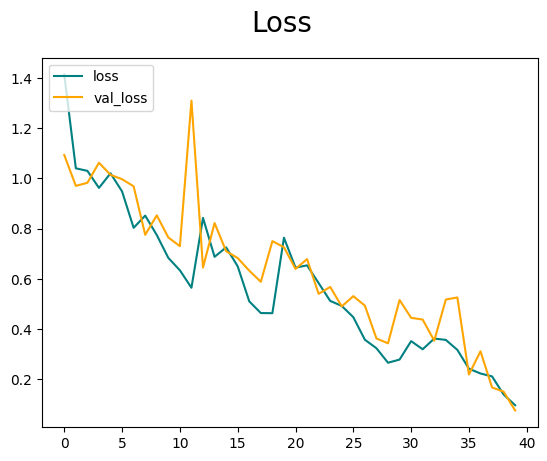

In [138]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

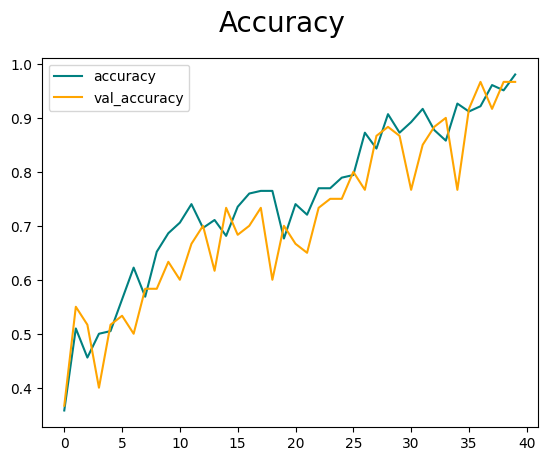

In [139]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [140]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [141]:
re = Recall()
#acc = SparseCategoricalAccuracy()
acc = tf.keras.metrics.CategoricalAccuracy()
pre = Precision()

In [142]:
len(test)

2

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X, batch_size=4)
    print(y)
    print(yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [143]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_onehot = tf.one_hot(y, depth=4)
    yhat = model.predict(X)
    print(y)
    print(y_onehot)
    print(yhat)
    pre.update_state(y_onehot, yhat)
    re.update_state(y_onehot, yhat)
    acc.update_state(y_onehot, yhat)
print(f'Precision:{pre.result().numpy()}, Recall ={re.result().numpy()}, Accuracy={acc.result()}')

1/1 [==============================] - 0s 438ms/step
[0 0 1 2 2 0 1 0 1 0 2 1]
tf.Tensor(
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]], shape=(12, 4), dtype=float32)
[[8.15247297e-01 1.40597507e-01 4.41550650e-02 6.21260404e-11]
 [9.99999940e-01 3.39156528e-28 3.86781522e-26 0.00000000e+00]
 [2.07103137e-02 9.47820246e-01 3.14693488e-02 2.25561486e-13]
 [9.25724886e-10 5.35588712e-02 9.46441054e-01 0.00000000e+00]
 [3.26118171e-01 8.22759718e-02 5.91605484e-01 4.01049192e-07]
 [9.99999940e-01 2.17012197e-31 1.85260411e-30 0.00000000e+00]
 [2.30699852e-02 9.76240695e-01 6.89304667e-04 3.28249434e-16]
 [9.19691265e-01 4.15032767e-02 3.88055108e-02 8.59658941e-11]
 [3.08622450e-01 5.84794223e-01 1.06583335e-01 3.64222791e-10]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.00334876e-14 5.33875312e-14 1.00000000e+00 0.00000000e+00]
 [1.1

In [144]:
print(f'Precision:{pre.result().numpy()}, Recall ={re.result().numpy()}, Accuracy={acc.result()}')

Precision:1.0, Recall =1.0, Accuracy=1.0
